In [1]:
sc

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
from pyspark.sql import SQLContext
import pickle
import string

In [4]:
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras import callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *
import distkeras.utils
from distkeras.job_deployment import Job

Using TensorFlow backend.


In [5]:
addition = 0
master_port = 5000
send_port = 8000
master_port += addition
send_port += addition
print master_port
print send_port

5000
8000


In [6]:
num_executors = 1
num_cores = 1
num_workers = num_executors * num_cores
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

chars = string.ascii_lowercase + string.ascii_uppercase
width, height, n_len, n_class = 130, 53, 4, len(chars)

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32*2**i, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
model = Model(input=input_tensor, outputs=x)

model.summary()

model.save('/home/ubuntu/models/weixin_rawmodel.h5')

from distkeras.job_deployment import graph
graph.append(tf.get_default_graph())

trainer = AEASGD(keras_model=model, worker_optimizer=optimizer, loss=loss, num_workers=num_workers, 
                 batch_size=32, features_col="features_normalized", label_col="newlabel", num_epoch=1,
                 communication_window=32, rho=5.0, learning_rate=0.1, master_port=master_port)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 53, 130, 3)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 53, 130, 32)   896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 51, 128, 32)   9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 25, 64, 32)    0           conv2d_2[0][0]                   
___________________________________________________________________________________________

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


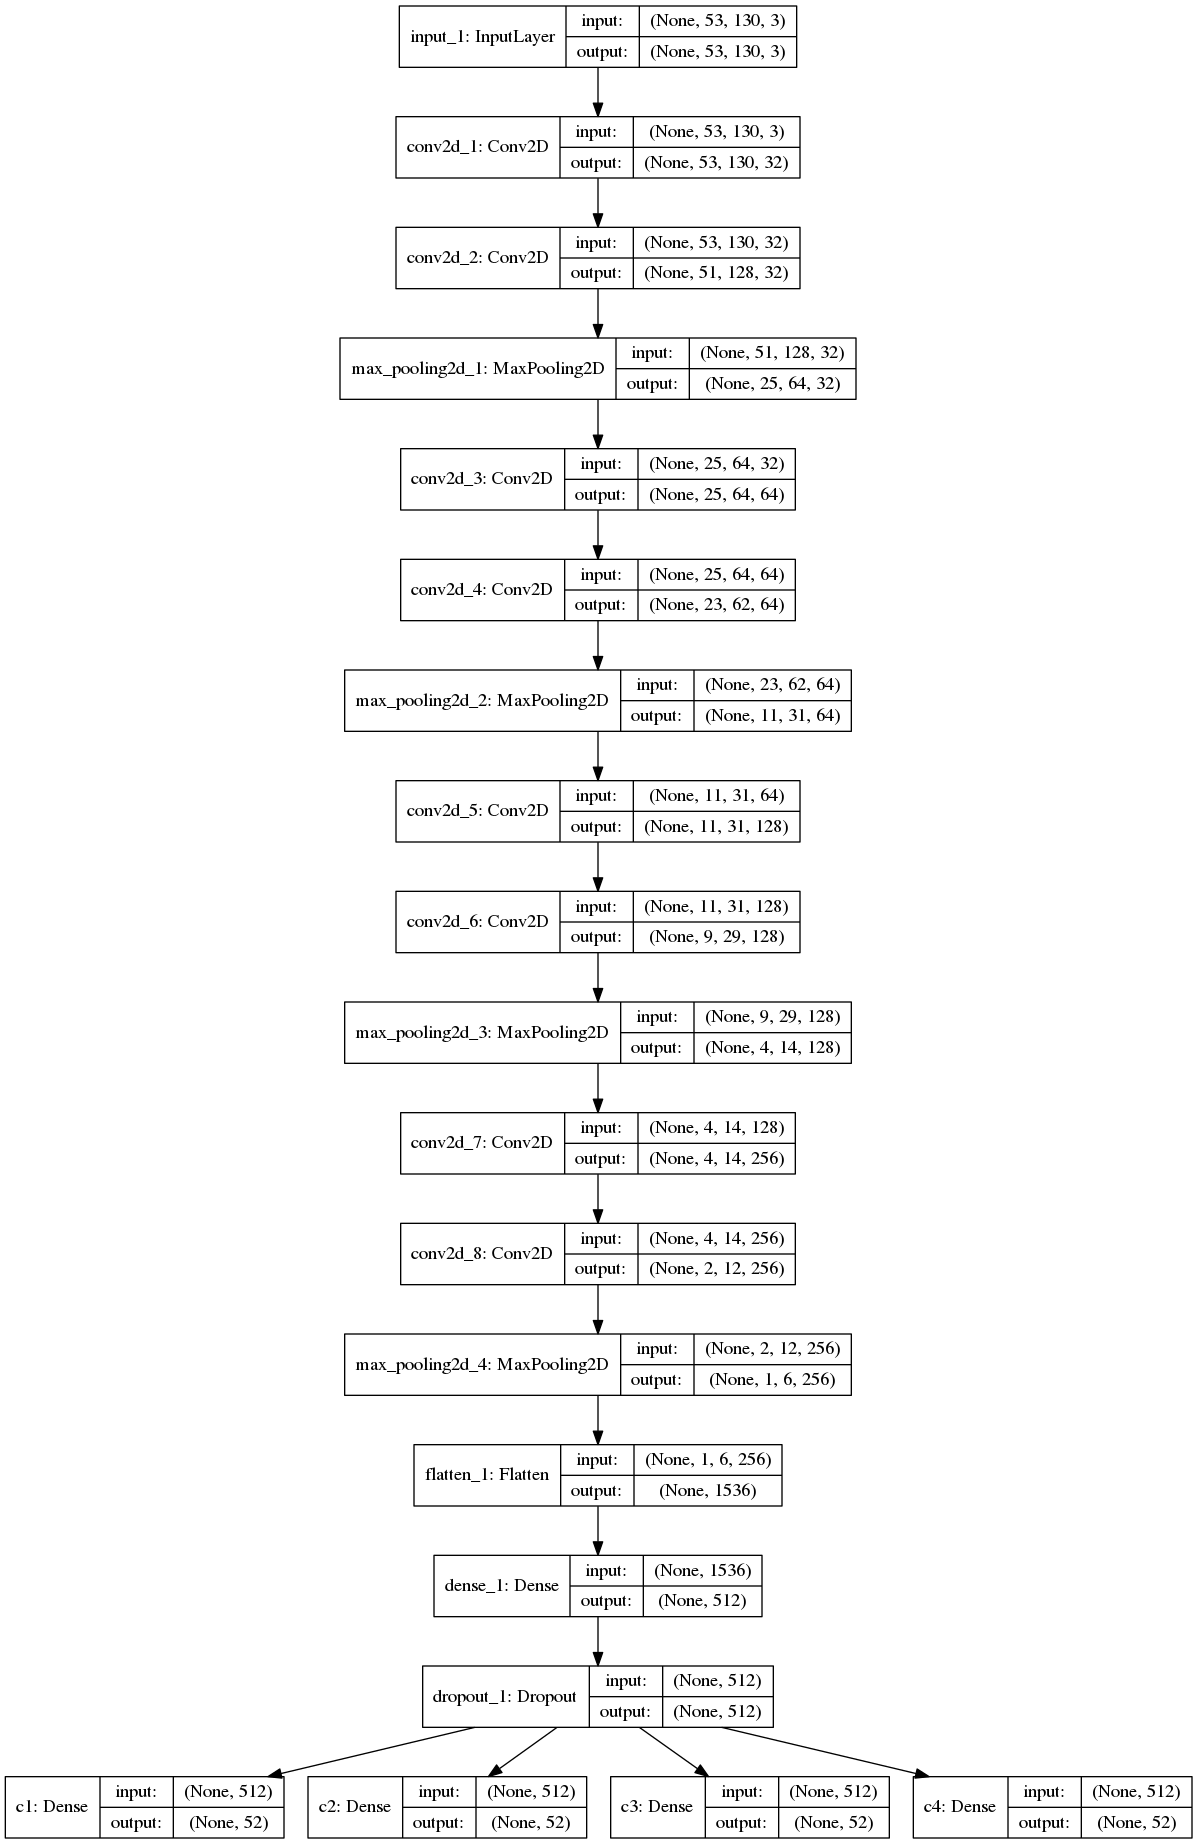

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="weixin_model.png", show_shapes=True)
Image('weixin_model.png')

In [8]:
job = Job("3Q20LA3MXU3N8Y9NVJ7A1T5WNHL2IWQSNNJ5V9I5P7MRJ8LSC33EN2DT3EWYLCJA",
          "user1",
          "data_path/training_set.parquet",
          1,
          1,
          trainer,
          1000,
          10)

In [ ]:
job.send_with_files('http://52.79.127.98:%d'%send_port, ['generator.py'])

In [ ]:
job.wait_completion()

In [ ]:
trained_model = job.get_trained_model()

In [ ]:
trained_model.get_weights()

In [12]:
sc.stop()